In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np


In [2]:
train_dir = r"C:\Users\bisha\Downloads\chest_xray-20250726T110654Z-1-001\chest_xray\train"
valid_dir = r"C:\Users\bisha\Downloads\chest_xray-20250726T110654Z-1-001\chest_xray\val"
test_dir  = r"C:\Users\bisha\Downloads\chest_xray-20250726T110654Z-1-001\chest_xray\test"

train_ds = image_dataset_from_directory(
    train_dir,
    image_size=(100,100),
    batch_size=35,
    color_mode="grayscale",
    label_mode='binary',
    shuffle=True
)

val_ds = image_dataset_from_directory(
    valid_dir,
    image_size=(100,100),
    batch_size=35,
    color_mode="grayscale",
    label_mode='binary',
    shuffle=False
)

test_ds = image_dataset_from_directory(
    test_dir,
    image_size=(100,100),
    batch_size=35,
    color_mode="grayscale",
    label_mode='binary',
    shuffle=False
)


Found 5226 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [3]:
# Normalization + data augmentation
data_augmentation = tf.keras.Sequential([  
    layers.RandomFlip("horizontal_and_vertical"),       # flip augmentation
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)  # slight rotation
])


In [4]:
print("Class Names:", train_ds.class_names)

Class Names: ['NORMAL', 'PNEUMONIA']


In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = (
    train_ds
    .map(lambda x, y: ((x / 255.0), y))
    .map(lambda x, y: (data_augmentation(x, training=True), y))
    .cache()
    .shuffle(1000)
    .prefetch(AUTOTUNE)
)
val_ds   = val_ds.map(lambda x, y: (x/255.0, y)).cache().prefetch(AUTOTUNE)
test_ds  = test_ds.map(lambda x, y: (x/255.0, y)).cache().prefetch(AUTOTUNE)


In [6]:
model = models.Sequential([
    layers.Input(shape=(100, 100, 1)),

    layers.Conv2D(32, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2,2)),
    

    layers.Conv2D(64, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.5),

    

    layers.Flatten(),
    layers.Dense(64),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(1, activation='sigmoid')
])

In [7]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 100, 100, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 100, 100, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 100, 100, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 50, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 50, 50, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 50, 50, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 40000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       2,560,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,579,585 (9.84 MB)

 Trainable params: 2,579,265 (9.84 MB)

 Non-trainable params: 320 (1.25 KB)

In [8]:
model.compile(
    optimizer='adamW',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [9]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop]
)


Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 56s 271ms/step - accuracy: 0.8804 - loss: 0.3140 - val_accuracy: 0.5000 - val_loss: 2.2799
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 256ms/step - accuracy: 0.9376 - loss: 0.1659 - val_accuracy: 0.5000 - val_loss: 2.9168
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 269ms/step - accuracy: 0.9550 - loss: 0.1297 - val_accuracy: 0.5000 - val_loss: 1.9978
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 42s 282ms/step - accuracy: 0.9617 - loss: 0.1108 - val_accuracy: 0.6875 - val_loss: 0.6951
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 44s 291ms/step - accuracy: 0.9684 - loss: 0.0928 - val_accuracy: 0.5000 - val_loss: 1.7997
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 45s 300ms/step - accuracy: 0.9757 - loss: 0.0731 - val_accuracy: 0.6250 - val_loss: 0.7215
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 47s 313ms/step - accuracy: 0.9746 - loss: 0.0719 - val_accuracy: 0.9375 - val_loss: 0.2816
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 45s 303ms/step - accuracy: 0.9834 - loss: 0

In [10]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.8638 - loss: 0.3208
Test Accuracy: 0.8638, Test Loss: 0.3208


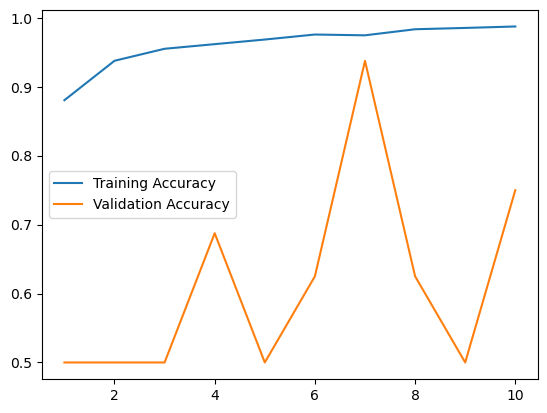

In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
epoch_list = list(range(1, len(history.history['accuracy']) + 1))  # values for x axis [1, 2, ..., # of epochs]
plt.plot(epoch_list, history.history['accuracy'], epoch_list, history.history['val_accuracy'])
plt.legend(('Training Accuracy', 'Validation Accuracy'))
plt.show()